In [ ]:
#Importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Importing Normalisation library
from sklearn.preprocessing import MinMaxScaler

# Importing Keras libraries and Packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# Importing Metrics libraries
import math
from sklearn.metrics import mean_squared_error

# Importing TPU Setup Libraries
# tf.enable_eager_execution()
# from keras.backend import clear_session


#Reading data

In [ ]:
data_train = pd.read_csv('/content/Google_Stock_Price_Train.csv')

# Data Pre-processing

In [ ]:
data_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [ ]:
training_set = data_train.iloc[:, 1:2].values
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

 # Feature Scaling

1 to 60 -> 61

2 to 61 -> 62 

3 to 62 -> 63

In [ ]:
sc = MinMaxScaler(feature_range= (0,1))


In [ ]:
scaled_training_set = sc.fit_transform(training_set)
scaled_training_set

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

## Creating Datastructure with 60 timesteps and 1 output

In [ ]:
## Using Tensorflow 

# dataset = tf.data.Dataset.from_tensor_slices(scaled_training_set)
# dataset = dataset.window(61, shift=1,drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(61))
# dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
# x_train = y_train = []
# for x, y in dataset:
#   x_train.append(x.numpy())
#   y_train.append(y.numpy())

In [ ]:
# Using Pandas and Slicing

x_train, y_train = zip(*[(scaled_training_set[i-60:i, 0]
                          ,scaled_training_set[i, 0])
                          for i in range(60, 1258)])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train.shape[1]

60

## Reshaping

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Setting Model Parameters

In [ ]:
INPUT_SHAPE = (x_train.shape[1], 1)
BATCH_SIZE = 32

# Model Creation

In [ ]:
# Step 1 - Initialising the RNN
rnn_regressor = Sequential()

In [ ]:
# Step 2 - First LSTM and Droput Layer
rnn_regressor.add(LSTM(units = 50, return_sequences = True, input_shape = INPUT_SHAPE))
rnn_regressor.add(Dropout(0.2))

In [ ]:
# Step 3 - Additional LSTM and Dropout Layers
rnn_regressor.add(LSTM(units = 50, return_sequences = True))
rnn_regressor.add(Dropout(0.2))

rnn_regressor.add(LSTM(units = 75, return_sequences = True))
rnn_regressor.add(Dropout(0.2))

rnn_regressor.add(LSTM(units = 100, return_sequences = True))
rnn_regressor.add(Dropout(0.2))

rnn_regressor.add(LSTM(units = 100))
rnn_regressor.add(Dropout(0.2))

In [ ]:
# Step 4 - Full Connection
rnn_regressor.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
rnn_regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# Summary of RNN model
rnn_regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 75)            37800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 75)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 100)           7

# Train the RNN Model

In [ ]:
EPOCHS = 100
history = rnn_regressor.fit(
    x = x_train,
    y = y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE
)

Epoch 1/100
38/38 [==============================] - 18s 207ms/step - loss: 0.0888
Epoch 2/100
38/38 [==============================] - 8s 216ms/step - loss: 0.0056
Epoch 3/100
38/38 [==============================] - 8s 211ms/step - loss: 0.0042
Epoch 4/100
38/38 [==============================] - 8s 205ms/step - loss: 0.0050
Epoch 5/100
38/38 [==============================] - 8s 208ms/step - loss: 0.0039
Epoch 6/100
38/38 [==============================] - 8s 208ms/step - loss: 0.0049
Epoch 7/100
38/38 [==============================] - 8s 211ms/step - loss: 0.0040
Epoch 8/100
38/38 [==============================] - 8s 210ms/step - loss: 0.0043
Epoch 9/100
38/38 [==============================] - 8s 219ms/step - loss: 0.0038
Epoch 10/100
38/38 [==============================] - 8s 207ms/step - loss: 0.0045
Epoch 11/100
38/38 [==============================] - 8s 206ms/step - loss: 0.0039
Epoch 12/100
38/38 [==============================] - 8s 212ms/step - loss: 0.0039
Epoch 13/100

# Prediction and Visualising the result

In [ ]:
data_test = pd.read_csv('/content/Google_Stock_Price_Test.csv')

In [ ]:
# Real stock Price
real_stock_price = data_test.iloc[:, 1:2].values

In [ ]:
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [ ]:
# Predicting Stock Price of Jan 2017
data_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)
inputs = data_total[len(data_total) - len(data_test) - 60:].values  # values for making this a numpy array

# Reshaping
inputs = inputs.reshape(-1,1)

In [ ]:
# Scaling
inputs = sc.transform(inputs) # transform must be used instead of fit_transform to apply the same tranformation which occured in the training set 

In [ ]:
# Creating Datastructure with 60 timesteps for test data
x_test = [inputs[i-60:i, 0] for i in range(60, 80)]    # For 20 Financial days
x_test = np.array(x_test)

In [ ]:
# Reshaping
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Prediction of Test Data with Trained RNN

In [ ]:
predicted_stock_price = rnn_regressor.predict(x_test)

In [ ]:
# Inversing the scaled data to original
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
predicted_stock_price

array([[775.7329 ],
       [773.27075],
       [774.2365 ],
       [775.25226],
       [778.1264 ],
       [783.29865],
       [787.051  ],
       [787.6662 ],
       [787.6606 ],
       [787.6325 ],
       [787.6394 ],
       [787.4964 ],
       [787.4181 ],
       [788.1217 ],
       [789.06055],
       [793.97235],
       [799.96344],
       [805.73694],
       [807.86475],
       [802.85834]], dtype=float32)

## Visualisation

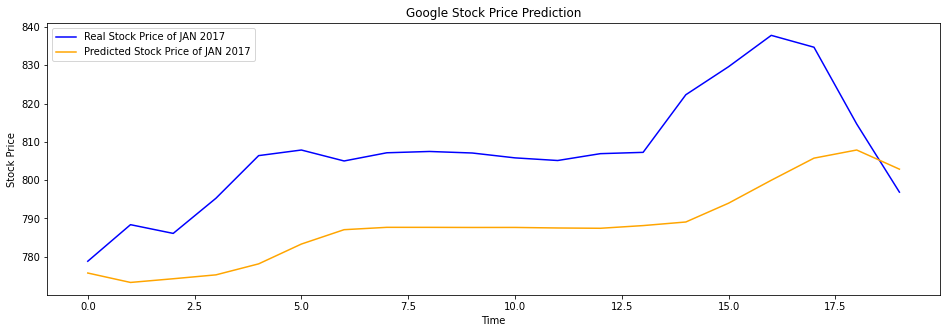

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(real_stock_price, color = 'blue', label = 'Real Stock Price of JAN 2017')
plt.plot(predicted_stock_price, color = 'orange', label = 'Predicted Stock Price of JAN 2017')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.show()

# Performance Evaluation

In [ ]:
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('Root Mean Squared Error of our RNN model: {}'.format(rmse))

Root Mean Squared Error of our RNN model: 22.100856598887603
